In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cfunc, types

##### Helper function

In [2]:
def rand_f(n):
    """
    Box-Muller: pair of random numbers drawn from a standard normal distribution.
    Generates `n` normally distributed random numbers using the Box-Muller transform.
    
    n: number of random numbers to generate
    """
    rand_n = np.zeros(n)    #array of size n to store the random numbers
    for ind1 in range(n):   #iterates over each element to generate a random number
        rsq = 100
        while (rsq>=1 or rsq == 0):     #generates two uniform random numbers v1 and v2 until their square sum rsq is less than 1 and non-zero.
            rand_s = np.random.rand()
            v1 = 2*rand_s - 1
            rand_s = np.random.rand()
            v2 = 2*rand_s - 1
            rsq = v1**2 + v2**2

        fac = np.sqrt(-2.0 * np.log(rsq) / rsq)  #computes a normally distributed random number using the Box-Muller formula.
        rand_n[ind1] = v1 * fac

    return rand_n   #array of n values drawn from a standard normal distribution.



#performs cubic spline interpolation  and 
# their second derivatives (y2a), and interpolates the value y at a new point x.
@jit(nopython=True)
def f_sc_splint(xa, ya, y2a, n, x):
    """
    Cubic spline interpolation function.
    Perform cubic spline interpolation given a set of known points (xa, ya) and their second derivatives (y2a).

    If x (cash_1) falls between two known points (cash and associated value function)
    => provide a weighted average of the known value functions (ya) by how close x is to each point (xa).
    

    xa, ya: arrays containing x and y coordinates of the data points.
    - xa = gcash (grid points for cash)
    - ya = V[:, t+1] (value function at t+1)
    y2a: array containing the second derivatives of ya at points xa (secd, output of the f_spline).
    n: number of data points (ncash).
    x: the x-coordinate at which interpolation is required (cash_1).

    Note: This can be done with linear interpolation but value function is often concave.
    So cubic spline interpolation provide more accurate approximation.
    """

    klo = 0
    khi = n-1
    while (khi-klo > 1):    #binary search between klo and khi to find segment in `xa` that contains `x`
        k = (khi + klo)//2
        if xa[k] > x:
            khi = k
        else:
            klo = k
    
    h = xa[khi] - xa[klo]
    a = (xa[khi] - x) / h   #interpolation weights for ya[klo] 
    b = (x - xa[klo]) / h   #interpolation weights for ya[khi]
    
    # Cubic Spline formula
    y = a * ya[klo] + b * ya[khi] + ((a**3 - a) * y2a[klo] + (b**3 - b) * y2a[khi]) * (h**2) / 6.0
    
    #clamping y to lie within the maximum and minimum values of ya to prevent extrapolation errors
    if y>ya[n-1]:
        y = ya[n-1]
    elif y<ya[0]:
        y = ya[0]


    return y


@jit(nopython=True)
def f_spline(x, y, n, gam):
    """
    Calculates the second derivatives of an interpolating function, for cubic spline interpolation.


    x, y: Arrays containing the x and y coordinates of the data points.
        - x: gcash
        - y: V[:, t]
    `n`: Number of data points (ncash).
    `gam`: Parameter used to set boundary conditions (1).
    """
    y2 = np.zeros(n)
    u = np.zeros(n)

    yp1 = x[0]**(-gam)
    y2[0] = -0.5    # Boundary condition
    u[0] = (3.0 / (x[1] - x[0])) * ((y[1] - y[0]) / (x[1] - x[0]) - yp1)

    for i in range(1, n-1): #computes y2 (second derivative) of y at each point, using a tridiagonal matrix solver
        sig = (x[i] - x[i-1]) / (x[i+1] - x[i-1])
        p = sig * y2[i-1] + 2.0
        y2[i] = (sig - 1.0) / p
        u[i] = (6.0 * ((y[i+1] - y[i]) / (x[i+1] - x[i]) - (y[i] - y[i-1]) / (x[i] - x[i-1])) / (x[i+1] - x[i-1]) - sig * u[i-1]) / p

    # Boundary condition
    y2[-1] = 0.0

    # Backsubstitution phase of the tridiagonal algorithm
    for k in range(n-2, -1, -1):
        y2[k] = y2[k] * y2[k+1] + u[k]

    return y2


def f_ntoil(value, grid, n):
    """
    Finds the index of a 'value' in a discretized 'grid'.

    value: value to be found in the grid
    grid: array of grid points
    n: number of grid points
    """
    if value >= grid[n-1]:  # Adjusted for zero-based index
        ind = n - 1         # If value is greater than the upper bound of the grid
    elif value < grid[0]:
        ind = 0             # If value is less than the lower bound of the grid
    else:
        ind = 1 + int((value - grid[0]) / (grid[1] - grid[0]))  #Linear interpolation between grid points ; as int(.) rounds down to the nearest integer.
    return ind

##### Parameters

In [3]:
# Variable Definitions

# Placeholder for filename setup - assuming file handling will be done differently in Python
filenames = [""] * 80  # Create a list of 80 empty strings


# Constants
tb = 20             #beginning of working age
tr = 66             #retirement age
td = 100            #max age
tn = td - tb + 1    #total number of years => number of periods in the life-cycle model


# Discretization state and control variables parameters
na      = 51    #nb of asset grid points
ncash   = 51    #nb of cash grid points
n       = 5     #fixed number of nodes
nc      = 21    #nb of consumption grid points


maxcash = 200.0                     #max cash level
mincash = 0.25                      #min cash level
aa      = -2.170042 + 2.700381      #coeff for modelling?
b1      = 0.16818                   #coeff for modelling?
b2      = -0.0323371 / 10           #coeff for modelling?
b3      = 0.0019704 / 100           #coeff for modelling?
ret_fac = 0.68212                   #retirement factor
smay    = 0.1                       #std multiplier for income shocks
smav    = 0.1                       #std multiplier for volatility? (related to a stochastic process?)
corr_v  = 0.0                       #corr coeff (here 0 ; between stock return and income process?)
corr_y  = 0.0                       #corr coeff (here 0)
rho     = 10.0                      #for utility function (preference param): relative risk aversion
delta   = 0.97                      #for utility function (preference param, $\beta$ in the paper)
psi     = 0.5                       #for utility function (preference param):  elasticity of intertemporal substitution
r       = 1.015                     #risk free rate
mu      = 0.04                      #expected return of risky assets
sigr    = 0.2                       #std of risky asset return

               

# Initialize arrays with zeros, ones, or specified values
survprob = np.zeros(tn - 1)         #survival probababilities
delta2  = np.zeros(tn - 1)
grid    = np.zeros(n)
weig    = np.zeros(n)               #weights associated with the grid points for integration
gret    = np.zeros(n)               #expected returns on the grid points
ones_n_1 = np.ones(n)
grid2   = np.zeros(n)
yp      = np.zeros((n, n))          #income process
yh      = np.zeros((n, n))          
nweig1  = np.zeros((n, n, n))
f_y     = np.zeros(tr - tb + 1)     #income function?
gy      = np.zeros(tr - tb)         #growth rate of income
gyp     = np.zeros((n, n, tn - 1))
gcash   = np.zeros(ncash)           #discretized values of cash-on-hand levels
lgcash  = np.zeros(ncash)           #log discretized values of cash-on-hand levels
ga      = np.zeros(na)              #grid for asset levels
riskret = np.zeros((na, n))         #return estimates
gc      = np.zeros(nc)              #grid for consumption levels
auxV    = np.zeros((na, nc))
vec_V   = np.zeros(na * nc)         #value function
secd    = np.zeros(ncash)           #store secondary derivatives
C       = np.zeros((ncash, tn))     #values of consumption
V       = np.zeros((ncash, tn))     #value function
A       = np.ones((ncash, tn))      #asset allocation   (across different cash level and periods)


nsim        = 10000                 #number of simulation paths
ones_nsim_1 = np.ones(nsim)
meanY       = np.zeros(tn)          #mean values of income
meanC       = np.zeros(tn)          #mean values of consumption
meanW       = np.zeros(tn)          #mean values of wealth
meanA       = np.zeros(tn)          #mean values of assets
meanS       = np.zeros(tn)
meanB       = np.zeros(tn)
meanWY      = np.zeros(tn)
meanalpha   = np.zeros(tn)
meanGPY     = np.zeros(tn)
cGPY        = np.zeros(tn)
meanYs      = np.zeros(tn)
meanCs      = np.zeros(tn)
meanWs      = np.zeros(tn)
simPY       = np.zeros((tn, nsim))
simGPY      = np.zeros((tn, nsim))
simY        = np.zeros((tn, nsim))
simC        = np.zeros((tn, nsim))
simW        = np.zeros((tn, nsim))
simA        = np.zeros((tn, nsim))
simS        = np.zeros((tn, nsim))
simB        = np.zeros((tn, nsim))
simW_Y      = np.zeros((tn, nsim))
simR        = np.zeros((tn, nsim))


# Initialization of survival probabilities
survprob = np.array([
    0.99845, 0.99839, 0.99833, 0.99830, 0.99827, 0.99826, 0.99824, 0.99820, 0.99813, 0.99804,
    0.99795, 0.99785, 0.99776, 0.99766, 0.99755, 0.99743, 0.99730, 0.99718, 0.99707, 0.99696,
    0.99685, 0.99672, 0.99656, 0.99635, 0.99610, 0.99579, 0.99543, 0.99504, 0.99463, 0.99420,
    0.99370, 0.99311, 0.99245, 0.99172, 0.99091, 0.99005, 0.98911, 0.98803, 0.98680, 0.98545,
    0.98409, 0.98270, 0.98123, 0.97961, 0.97786, 0.97603, 0.97414, 0.97207, 0.96970, 0.96699,
    0.96393, 0.96055, 0.95690, 0.95310, 0.94921, 0.94508, 0.94057, 0.93570, 0.93031, 0.92424,
    0.91717, 0.90922, 0.90089, 0.89282, 0.88503, 0.87622, 0.86576, 0.85440, 0.84230, 0.82942,
    0.81540, 0.80002, 0.78404, 0.76842, 0.75382, 0.73996, 0.72464, 0.71057, 0.69610, 0.68090
])

# Generate file names based on the number of periods
filenames = [f"year{t:02d}" for t in range(1, tn)]

# n is the number of grid to approximate the standard normal
# if n=2 then grid = [-1, 1] and weig = [0.5, 0.5] (means -1 and 1 have equal probabilities) => mean = 0.5*(-1)+0.5*(1) = 0, std = 1
# To scale it to a normal with standard deviation 0.2, you multiply the node values by 0.2, so the nodes become +/-0.2
# These nodes represent log-normal variables, so they are exponentiated ( exp(0.2ngrid - 0.50.2^2 )

# here n = 5, so grid = [-2.85697001387280, -1.35562617997427, 0.00000000000000, 1.35562617997426, 2.85697001387280]
# and weig = [0.01125741132772, 0.22207592200561, 0.53333333333333, 0.22207592200561, 0.01125741132772]

# Grid initialization with n nodes as standard normal distribution
grid[0] = -2.85697001387280
grid[1] = -1.35562617997427
grid[2] = 0.00000000000000
grid[3] = 1.35562617997426
grid[4] = 2.85697001387280

weig[0] = 0.01125741132772
weig[1] = 0.22207592200561
weig[2] = 0.53333333333333
weig[3] = 0.22207592200561
weig[4] = 0.01125741132772

##### Computation foundation

In [4]:
gret = r + mu + grid * sigr #computes the expected returns on assets
# Compute over a normal standard distribution. Sclaing to a normal with a standard deviation of sigr.
# Give a distribution of returns on assets.

#r: The risk-free rate.
#mu: The mean excess return over the risk-free rate.


# Weights for some numerical integration
for i6 in range(n):
    for i7 in range(n):
        for i8 in range(n):
            nweig1[i6, i7, i8] = weig[i6] * weig[i7] * weig[i8]


#nweig1(i6,i7,i8): Stores the product of weights for combinations of three points 
# => further calculate expected values over a multivariate distribution of economic shocks or returns.

theta = (1.0 - rho) / (1.0 - 1.0 / psi)
psi_1 = 1.0 - 1.0 / psi
psi_2 = 1.0 / psi_1

#theta: adjusts the effective discounting applied to future utility.
#psi_1 , psi_2: modify the curvature of the utility function, influencing the trade-offs between consumption at different times.

In [5]:
gret

array([0.483606  , 0.78387476, 1.055     , 1.32612524, 1.626394  ])

##### Grids for the State Variables and for Portfolio Rule

In [6]:
ga = np.array([(na - i) / (na - 1.0) for i in range(1, na+1)])  #Asset Allocation Grid
# ga: grid for asset levels, ranging from 0 to 1, with na points. 
# Representing different level of asset allocation between risk-free and risky assets
# ga(1,1) = 1   =>  allocation to risky assets is 100%
# ga(na,1) = 0  =>  allocation to risky assets is 0% (full invest in risky asset)


riskret = np.zeros((na, n)) #Risk Adjusted Returns
for i5 in range(na):
    for i8 in range(n):
        riskret[i5, i8] = r * (1 - ga[i5]) + gret[i8] * ga[i5]

# Expected returns riskret for each combination of asset allocation (ga, combination of risky and risk-free asset allocation).
# For each asset allocation: the risk return us computed for each node (= each expected return outcome)


l_maxcash = np.log(maxcash)
l_mincash = np.log(mincash)
stepcash = (l_maxcash - l_mincash) / (ncash - 1)

lgcash = np.array([l_mincash + i * stepcash for i in range(ncash)])
# lgcash: Logarithm of cash levels, which ensures a more even distribution of values.
# Especially when dealing with a wide range of cash levels


gcash = np.exp(lgcash)
# Sets up a logarithmically spaced grid for cash levels gcash.

##### Labor Income

In [7]:
# Labor Income Calculations
for i1 in range(n):
    grid2[:] = grid[i1] * corr_y + grid[:] * (1 - corr_y**2)**0.5
    yh[:, i1] = np.exp(grid2[:] * smay)

for i1 in range(n):
    grid2[:] = grid[i1] * corr_v + grid[:] * (1 - corr_v**2)**0.5
    yp[:, i1] = grid2[:] * smav


for i1 in range(tb, tr + 1):
    f_y[i1 - tb] = np.exp(aa + b1 * i1 + b2 * i1**2 + b3 * i1**3) #future income (f_y) using a polynomial based on age (i1)


for i1 in range(tb, tr):
    gy[i1 - tb] = f_y[i1 - tb + 1] / f_y[i1 - tb] - 1.0
    for i2 in range(n):
        gyp[:, i2, i1 - tb] = np.exp(gy[i1 - tb] + yp[:, i2])

for i1 in range(tr - tb, tn - 1):   #no growth in income after retirement
    for i2 in range(n):
        gyp[:, i2, i1] = np.exp(np.zeros(n))  # Effectively exp(0) is 1, so this just sets it to 1


##### Terminal Period

In [8]:
# Set terminal consumption values and asset values
for i1 in range(ncash):
    C[i1, tn - 1] = gcash[i1]  #Consumption to Cash-on-Hand


# All remaining cash is consumed in the last period of life, as there is no further period to save for.
A[:, tn - 1] = 0.0  # Set all assets to 0 at the terminal period.


# Calculate terminal values for the value function
for i1 in range(ncash):
    V[i1, tn - 1] = C[i1, tn - 1] * ((1.0 - delta)**(psi / (psi - 1.0)))    ##Terminal Value Function


secd = f_spline(gcash, V[:, tn-1], ncash, 1.0)  # Compute spline coeff (derivative) for further cubic interpolation
#Computes and stores the second derivatives of the value function V at the terminal period across different levels of cash-on-hand.

##### Retirement period

In [9]:
for i1 in range(td - tr):   # Iterates from the last period backwards to the start of retirement
    t = tn - i1 - 2         # from 79 -> 46
    print(t)
    
    # Calculates possible consumption amounts for each cash level based on
    # previous consumption and changes in cash levels
    for i3 in range(ncash):
        if i3 == 0:
            maxc = C[i3, t+1]
            minc = maxc / 2
        else:
            minc = C[i3 - 1, t]
            if i3 < 9:  # For the first 9 cash levels, consumption is linearly interpolated between the previous and next consumption levels
                maxc = minc + (gcash[i3] - gcash[i3 - 1])
            else:
                mpc = max((C[i3 - 1, t] - C[i3 - 9, t]) / (gcash[i3 - 1] - gcash[i3 - 9]), 0.1)
                maxc = minc + mpc * (gcash[i3] - gcash[i3 - 1])

        stepc = (maxc - minc) / (nc - 1)    

        gc = np.array([minc + i9 * stepc for i9 in range(nc)])    #Define consumption grid for this cash level


        # Computes utility for each combination of consumption and associated asset level.
        # integrating future value and survival probabilities.
        for i4 in range(nc):
            u = (1.0 - delta) * (gc[i4]**psi_1)     #Current period utility from consumption.
            sav = gcash[i3] - gc[i4]                #Saving: difference between current cash and consumption

            for i5 in range(na):
                auxVV = 0.0
                
                for i8 in range(n): #utility of each potential decision based on the future value (V) and the nodes.
                    cash_1 = riskret[i5, i8] * sav + ret_fac
                    cash_1 = max(min(cash_1, gcash[-1]), gcash[0])
                    int_V = f_sc_splint(gcash, V[:, t+1], secd, ncash, cash_1)
                    auxVV = auxVV + weig[i8] * survprob[t] * (int_V**(1.0 - rho))

                auxV[i5, i4] = (u + delta * (auxVV**(1.0 / theta)))**psi_2

        
        # Identifies the optimal consumption (C) and asset allocation (A) that maximizes the 
        # utility for each cash level.
        vec_V = auxV.T.flatten()

        V[i3, t] = np.max(vec_V)  #decision that maximizes utility for each period and cash level.
        pt = np.argmax(vec_V)

        aux2 = pt // na
        C[i3, t] = gc[aux2]
        A[i3, t] = ga[pt%na]

    secd = f_spline(gcash, V[:, t], ncash, 1.0)  # Update spline coefficients for the next period's value function interpolation


79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46


In [ ]:
for i1 in range(td - tr):
    t = tn - i1 - 1  # Adjust for zero-based indexing
    filename = f"{filenames[t]}.txt"  # Filenames array should be properly initialized
    with open(filename, 'w') as fileID:
        # Write data for assets at time t
        for i5 in range(ncash):
            fileID.write(f"{A[i5, t]:12.8f} {gcash[i5]:12.8f}\n")
        
        # Write data for consumption at time t
        for i5 in range(ncash):
            fileID.write(f"{C[i5, t]:12.8f} {gcash[i5]:12.8f}\n")
        
        # Write data for value function at time t
        for i5 in range(ncash):
            fileID.write(f"{V[i5, t]:12.8f} {gcash[i5]:12.8f}\n")

##### Other Periods

In [10]:
for i1 in range(tr - tb):   # Iterate from the retirement to the start of working age
    t = tr - tb - i1 - 1    # from 45 -> 0
    print(t)
    for i3 in range(ncash):
        if i3 == 0:
            minc = gcash[i3] / 5
            maxc = 0.999 * gcash[i3]
        else:
            minc = C[i3 - 1, t]
            if i3 < 9:  
                maxc = minc + (gcash[i3] - gcash[i3 - 1])
            else:
                mpc = max((C[i3 - 1, t] - C[i3 - 9, t]) / (gcash[i3 - 1] - gcash[i3 - 9]), 0.1)
                maxc = minc + mpc * (gcash[i3] - gcash[i3 - 1])

        # range of possible consumption values (gc) for each level of cash on hand (gcash).
        stepc = (maxc - minc) / (nc - 1)
        gc = np.array([minc + i * stepc for i in range(nc)])    #consumption grid for this cash level

        for i4 in range(nc):
            u = (1.0 - delta) * (gc[i4] ** psi_1)   #Immediate utility from consumption
            sav = gcash[i3] - gc[i4]                #Savings after consuming

            for i5 in range(na):
                auxVV = 0.0
                for i6 in range(n):
                    for i8 in range(n):
                        for i7 in range(n):
                            cash_1 = riskret[i5, i8] * sav / gyp[i6, i8, t] + yh[i7, i8]
                            cash_1 = max(min(cash_1, gcash[-1]), gcash[0])
                            int_V = f_sc_splint(gcash, V[:, t + 1], secd, ncash, cash_1)
                            auxVV = auxVV + nweig1[i6, i7, i8] * survprob[t] * ((int_V * gyp[i6, i8, t])** (1.0 - rho))

                auxV[i5, i4] = (u + delta * (auxVV ** (1.0 / theta))) ** psi_2

        vec_V = auxV.flatten(order='F')
        V[i3, t] = np.max(vec_V)
        pt = np.argmax(vec_V)
        aux2 = pt // na
        C[i3, t] = gc[aux2]
        A[i3, t] = ga[pt - na * aux2]

    #Updates 2nd derivatives for spline interpolation of the value function
    secd = f_spline(gcash, V[:, t], ncash, 1.0)


45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [ ]:
for i1 in range(tr - tb):
    t = tr - tb - i1
    filename = f"{filenames[t]}.txt"  # Make sure filenames are pre-populated correctly
    with open(filename, 'w') as fileID:
        # Write data for assets at time t
        for i5 in range(ncash):
            fileID.write(f"{A[i5, t]:12.8f} {gcash[i5]:12.8f}\n")
        
        # Write data for consumption at time t
        for i5 in range(ncash):
            fileID.write(f"{C[i5, t]:12.8f} {gcash[i5]:12.8f}\n")
        
        # Write data for the value function at time t
        for i5 in range(ncash):
            fileID.write(f"{V[i5, t]:12.8f} {gcash[i5]:12.8f}\n")

##### Simulation

In [ ]:
# Simulation process for modeling a life-cycle.
# Generating random shocks to simulate variations in income and returns. 
# Calculating cumulative wealth, and optimizing decisions over time based on these stochastic elements.

#f_randn(1) function is used to generate random normal shocks

# Simulations for economic variables
for i1 in range(nsim//2):
    eps_y = rand_f(1)
    simPY[0, i1] = eps_y * smav
    simPY[0, (nsim//2) + i1] = -eps_y * smav
    simGPY[0, i1] = 1.0
    simGPY[0, nsim//2 + i1] = 1.0
    simTY = rand_f(1)
    simY[0, i1] = np.exp(simTY * smay)
    simY[0, nsim//2 + i1] = np.exp(-simTY * smay)

    for i2 in range(1, tr-tb):
        w = i2 + tb - 1
        eps_y = rand_f(1)
        simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
        simPY[i2, nsim//2 + i1] = -eps_y * smav + simPY[i2-1, i1]
        simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
        simGPY[i2, nsim//2 + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, nsim//2 + i1]) / np.exp(simPY[i2-1, i1])
        simTY = rand_f(1)
        simY[i2, i1] = np.exp(simTY * smay)
        simY[i2, nsim//2 + i1] = np.exp(-simTY * smay)

# For each simulation, initial labor income (simY) is determined by an exponential function of the shock.
# Income varies according to a log-normal distribution
# simGPY represents the growth factor of previous year's income, adjusted for the shock.


# Post-retirement fixed values
for t in range(tr-tb, tn):
    simY[t, :] = ret_fac
    simGPY[t, :] = 1.0


# Simulate returns
for t in range(tn):
    for i1 in range(nsim//2):
        eps_r = rand_f(1)
        simR[t, i1] = mu + r + sigr * eps_r
        simR[t, nsim//2 + i1] = mu + r - sigr * eps_r


# Calculate wealth dynamics
for t in range(tn):
    for i1 in range(nsim):
        simW_Y[t, i1] = simW[t, i1] / simY[t, i1]
        cash = simW[t, i1] + simY[t, i1]
        i_net_cash2 = f_ntoil(np.log(cash), lgcash, ncash)
        #ic1 = i_net_cash2
        #ic2 = i_net_cash2 + 1
        ic1 = i_net_cash2 - 1
        ic2 = i_net_cash2
        ttc = (cash - gcash[ic1]) / (gcash[ic2] - gcash[ic1])
        print(ttc)
        ttc = max(min(1.0, ttc), 0.0)
        simC[t, i1] = (1 - ttc) * C[ic1, t] + ttc * C[ic2, t]
        simA[t, i1] = (1 - ttc) * A[ic1, t] + ttc * A[ic2, t]
        simC[t, i1] = min(simC[t, i1], 0.9999 * cash)
        sav = cash - simC[t, i1]
        simS[t, i1] = simA[t, i1] * sav         #should be simB[t, i1] = simA[t, i1] * sav ? based on ga and riskret
        simS[t, i1] = min(simS[t, i1], sav)
        simB[t, i1] = sav - simS[t, i1]
        if t < tn - 1:
            simW[t + 1, i1] = (simB[t, i1] * r + simS[t, i1] * simR[t, i1]) / simGPY[t + 1, i1]


# Calculate means across simulations
meanC = np.mean(simC, axis=1)
meanY = np.mean(simY, axis=1)
meanW = np.mean(simW, axis=1)
meanS = np.mean(simS, axis=1)
meanB = np.mean(simB, axis=1)
meanWY = np.mean(simW_Y, axis=1)
meanalpha = np.mean(simA, axis=1)
meanGPY = np.mean(simGPY, axis=1)

##### Plot from simulation

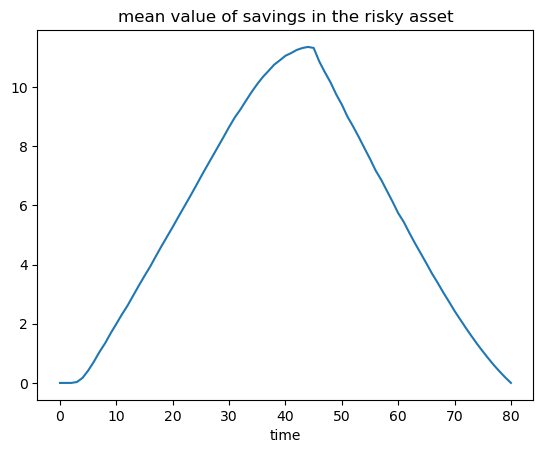

In [25]:
plt.plot(meanB)
plt.title("mean value of savings in the risky asset")
#set the x and y axis
plt.xlabel("time")
plt.show()

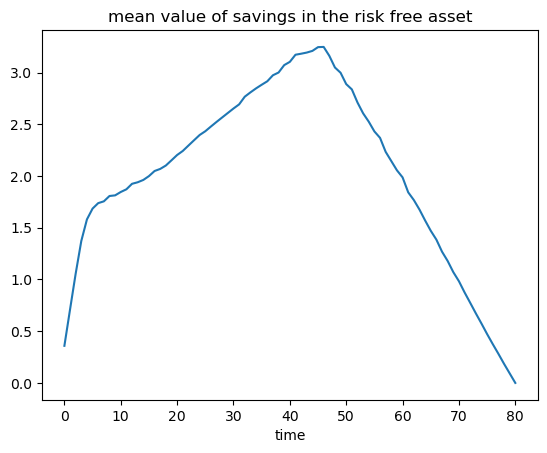

In [24]:
plt.plot(meanS)
plt.title("mean value of savings in the risk free asset")
plt.xlabel("time")
plt.show()

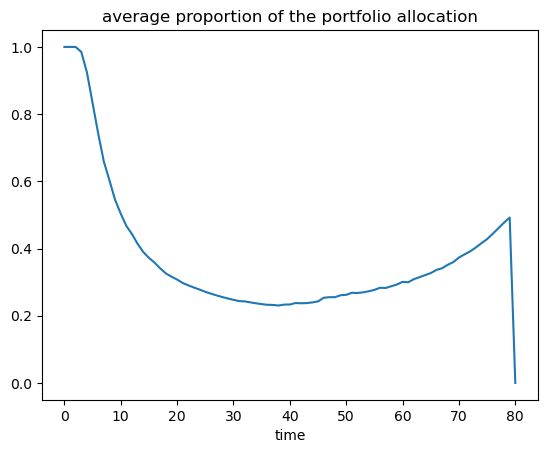

In [27]:
plt.plot(meanalpha)
plt.title("average proportion of the portfolio allocation")
plt.xlabel("time")
plt.show()

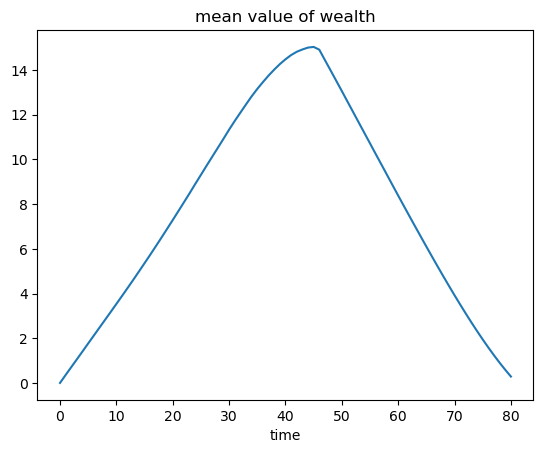

In [19]:
plt.plot(meanW)
plt.title("mean value of wealth")
plt.xlabel("time")
plt.show()

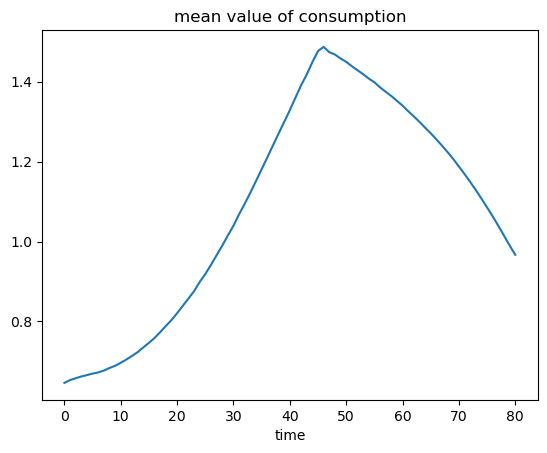

In [20]:
plt.plot(meanC)
plt.title("mean value of consumption")
plt.xlabel("time")
plt.show()

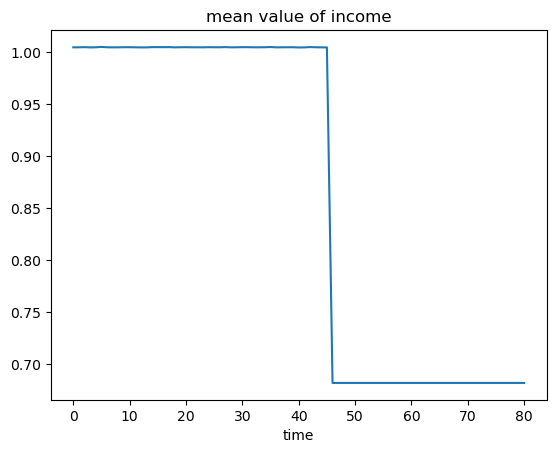

In [21]:
plt.plot(meanY)
plt.title("mean value of income")
plt.xlabel("time")
plt.show()

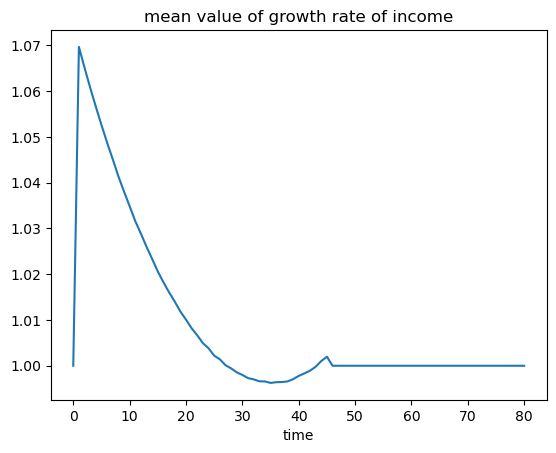

In [22]:
plt.plot(meanGPY)
plt.title("mean value of growth rate of income")
plt.xlabel("time")
plt.show()

In [ ]:
# Save CWY data
with open('CWY.txt', 'w') as fileID:
    for i2 in range(tn):
        fileID.write(f"{meanC[i2]:12.8f} {meanW[i2]:12.8f} {meanY[i2]:12.8f} {meanGPY[i2]:12.8f}\n")

# Calculate cumulative growth factor cGPY and adjusted means
cGPY[0] = 1.0
for i2 in range(1, tn):
    cGPY[i2] = cGPY[i2 - 1] + (meanGPY[i2] - 1)

meanCs = meanC * cGPY
meanWs = meanW * cGPY
meanYs = meanY * cGPY

# Save CWYs data
with open('CWYs.txt', 'w') as fileID:
    for i2 in range(tn):
        fileID.write(f"{meanCs[i2]:12.8f} {meanWs[i2]:12.8f} {meanYs[i2]:12.8f}\n")

# Save SB data
with open('SB.txt', 'w') as fileID:
    for i2 in range(tn):
        fileID.write(f"{meanS[i2]:12.8f} {meanB[i2]:12.8f} {meanalpha[i2]:12.8f}\n")


CWy: mean value of consumption, wealth, Y (income), GPY (income growth).

Cwys: mean value of consumption, wealth, Y (income), adjusted by the growth rate.

SB: mean value of savings in the risk-free asset, savings in the risky asset, portfolio allocation.
